# Gender recognition using Tensorflow v2 and InceptionV3 on entire dataset
### Inspiration
I have adapted this notebook from [Marcos Alvarado's notebook](https://www.kaggle.com/bmarcos/image-recognition-gender-detection-inceptionv3)

### Dataset
In this project, we will use the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is available on Kaggle.  
You can download dataset from Kaggle
(https://www.kaggle.com/jessicali9530/celeba-dataset):

#### Overall

The dataset contains:
- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

#### Data Files

imgalignceleba.zip: All the face images, cropped and aligned

listevalpartition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing

listbboxceleba.csv: Bounding box information for each image. "x1" and "y1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box

listlandmarksalign_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth

listattrceleba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

### Modelling and structure

#### Using Inception V3 model
I am using a pretrained Inception V3 model for which I will retrain some layers and fix the first layers. I will also attach new output layers to perform the new classification task. 

#### Target variable
As my target variable, I only use the gender feature available in the dataset and detect if the image shows a man or a woman.

#### Strategy:

Keras ImageDataGenerator and flow_from_dataframe is used to avoid loading all images in memory and fit the model on the entire dataset.
##### Training Data 
##### Testing Data
##### Generating new predictions

### Inception V3
The inception model (https://keras.io/api/applications/inceptionv3/) is available from Keras. We can either download pre-trained model or else can connect the notebook with the dataset using  "imagenet" as weights. 

# Import Libraries

In [1]:
import os

import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.preprocessing import image

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

import tensorflow as tf
print(f"Built using tensorflow version {tf.__version__}")

Built using tensorflow version 2.3.1


In [2]:
%matplotlib inline

### Define Variables
Set the main folder, images folder, image width, image height and other training parameters.

In [3]:
# set variables 
main_folder = "../input/celeba-dataset"
images_folder = os.path.join(main_folder, 'img_align_celeba', 'img_align_celeba')

IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 128
NUM_EPOCHS = 10

## Read dataset
Read Dataset and display data in readable format.
* '1' denotes feature is present
* '-1' denotes the feature is not present

Here, after reading the 'list_attr_celeba.csv', all the values of column 'Male' is replaced by column name "gender" having values as Male(1) and Female(-1)  

In [4]:
df_imgs = pd.read_csv(os.path.join(main_folder, 'list_attr_celeba.csv'), usecols=["image_id", "Male"])  
df_imgs.replace(to_replace={"Male": -1}, value="Female", inplace=True)
df_imgs.replace(to_replace={"Male": 1}, value="Male", inplace=True)
df_imgs.rename(columns={"Male": "gender"}, inplace=True)
df_imgs.head() 

,image_id,gender
0,000001.jpg,Female
1,000002.jpg,Female
2,000003.jpg,Male
3,000004.jpg,Female
4,000005.jpg,Female


### Visualizing Data
Displays the class distribution of 'gender' 

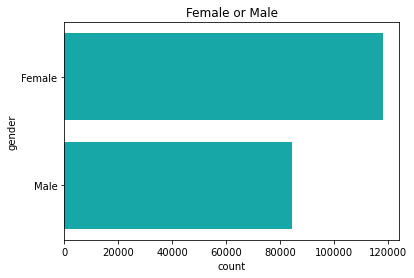

In [5]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='gender', data=df_imgs, color="c")
plt.show()

The dataset is slightly imbalanced in gender class distribution.

### Data Partitioning into train, valid and test

The dataset includes file 'list_eval_partition.csv' which provides us with the following partition:
- 0: train
- 1: valid
- 2: test

In [6]:
df_partition = pd.read_csv(os.path.join(main_folder, 'list_eval_partition.csv'))
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [7]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Merging partition with labels on image_id
- Joining partition and labels dataframe 
- Renaming image_id with the image path

In [8]:
df_imgs = df_imgs.merge(df_partition, on="image_id")
df_imgs.loc[:, "image_id"] = df_imgs.loc[:, "image_id"].apply(lambda x: os.path.join(images_folder, x))
df_imgs.head()

,image_id,gender,partition
0,../input/celeba-dataset/img_align_celeba/img_a...,Female,0
1,../input/celeba-dataset/img_align_celeba/img_a...,Female,0
2,../input/celeba-dataset/img_align_celeba/img_a...,Male,0
3,../input/celeba-dataset/img_align_celeba/img_a...,Female,0
4,../input/celeba-dataset/img_align_celeba/img_a...,Female,0


#### Creating the train, valid and test dataframes 
Train, Valid and Test dataframes will contain 2 features.i.e  
image_id and the label ("Male" or "Female")

In [9]:
df_train = df_imgs.loc[df_imgs.loc[:, "partition"] == 0, 
                      ["image_id", "gender"]]
df_valid = df_imgs.loc[df_imgs.loc[:, "partition"] == 1, 
                      ["image_id", "gender"]]
df_test = df_imgs.loc[df_imgs.loc[:, "partition"] == 2, 
                      ["image_id", "gender"]]

### Data Augmentation
Using the image data generator and flow_from_dataframe methods to load images from a dataframe

Found 1 validated image filenames.
Label: ['Female']


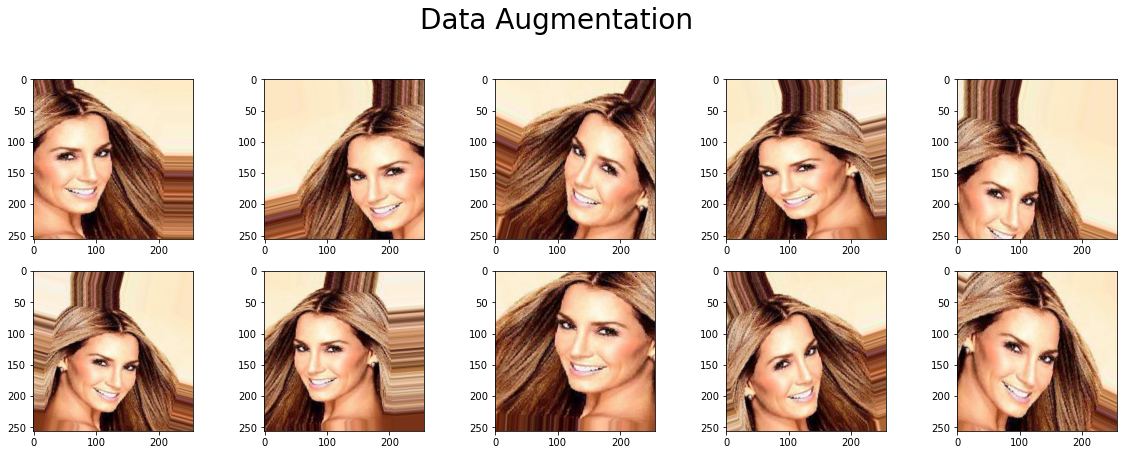

In [10]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  rescale=1./255,
    
)

# load one image and reshape
def display_image(img: pd.DataFrame) -> None:
    """"""

    # plot 10 augmented images of the loaded image
    plt.figure(figsize=(20,10))
    plt.suptitle('Data Augmentation', fontsize=28)

    i = 0
    for batch in datagen.flow_from_dataframe(img,
                                             batch_size=1,
                                             x_col="image_id", 
                                             y_col="gender",
                                             class_mode="raw",
                                             image_size=(IMG_WIDTH, IMG_HEIGHT)):
        batch_image = batch[0]
        batch_label = batch[1]
        plt.subplot(3, 5, i+1)
        plt.grid(False)
        plt.imshow(batch_image.reshape(256,256, 3))
        
        if i == 9:
            break
        i += 1
    print(f"Label: {batch_label}")
    plt.show()

display_image(df_imgs.loc[:0, :])

## Creating Train and Validation data generators

##### Train Data Generators

In [11]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  #brightness_range=[0.4,1.5],
  rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    batch_size=20,
    x_col="image_id", 
    y_col="gender",
    class_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    validate_filenames=False)

Found 162770 non-validated image filenames belonging to 2 classes.


##### Test Data Generators

In [12]:
valid_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
)

valid_generator = valid_datagen.flow_from_dataframe(
    df_valid,
    batch_size=20,
    x_col="image_id", 
    y_col="gender",
    class_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    validate_filenames=False)

Found 19867 non-validated image filenames belonging to 2 classes.


## Importing InceptionV3 Model

#### Inception-V3 model structure
This is the structure of the Inception-V3 model, developed over the imagenet dataset.


<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>
source: https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png

The top layers (including classification) are not included.

In [13]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
# Lock initial layers to do not be trained
for layer in inc_model.layers[:52]:
    layer.trainable = False

87916544/87910968 [==============================] - 2s 0us/step
number of layers: 311


### Adding custom Layers

Layers to be trained with the new model.

In [14]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Final model

In [15]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# compile the model
model_.compile(optimizer="adam", 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

#### Making sure to use the best model from training according to its performance on the valid set

In [16]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

#### Fit the model

In [17]:
hist = model_.fit(train_generator,
                  validation_data=valid_generator,
                  steps_per_epoch=len(df_train)//BATCH_SIZE,
                  validation_steps=len(df_valid) // BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  callbacks=[checkpointer],
                  verbose=1
                    )

Epoch 1/10
1271/1271 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8221
Epoch 00001: val_loss improved from inf to 0.23832, saving model to weights.best.inc.male.hdf5
1271/1271 [==============================] - 645s 507ms/step - loss: 0.3862 - accuracy: 0.8221 - val_loss: 0.2383 - val_accuracy: 0.9000
Epoch 2/10
1271/1271 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9185
Epoch 00002: val_loss improved from 0.23832 to 0.10064, saving model to weights.best.inc.male.hdf5
1271/1271 [==============================] - 611s 481ms/step - loss: 0.2053 - accuracy: 0.9185 - val_loss: 0.1006 - val_accuracy: 0.9587
Epoch 3/10
1271/1271 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9319
Epoch 00003: val_loss did not improve from 0.10064
1271/1271 [==============================] - 588s 463ms/step - loss: 0.1743 - accuracy: 0.9319 - val_loss: 0.1127 - val_accuracy: 0.9568
Epoch 4/10
1271/1271 [============================

### Plotting loss function value through epochs

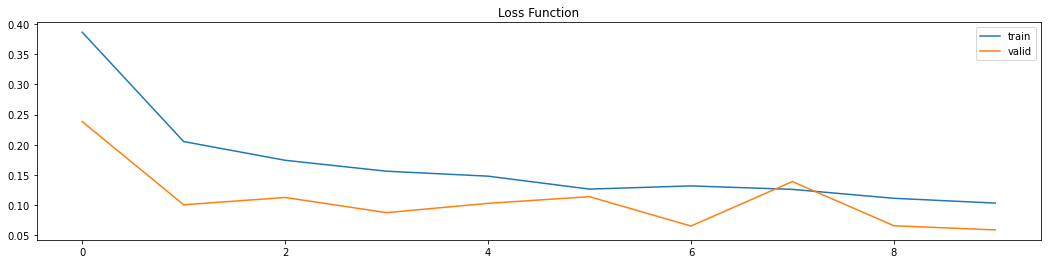

In [18]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

### Plotting accuracy through epochs

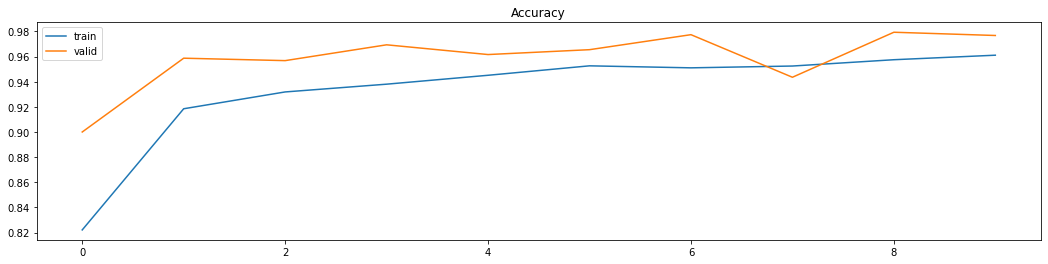

In [19]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

#### Select and use the best model from training according to the validation set

In [20]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

### Generating predictions on Test data

In [21]:
test_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    batch_size=20,
    x_col="image_id", 
    y_col="gender",
    class_mode="raw",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


In [22]:
# generate prediction
model_predictions = model_.predict(test_generator, steps=len(df_test))

#### Model Evaluation

In [23]:
# report test accuracy
preds = np.array(model_predictions > 0.5).astype(int)
test_accuracy = 100 * accuracy_score(preds, df_test.loc[:, "gender"].replace({"Male": 1, "Female": 0}).values)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(df_test.loc[:, "gender"].replace({"Male": 1, "Female": 0}).values, preds))

Model Evaluation
Test accuracy: 96.9141%
f1_score: 0.9599271402550091


### Generating new predictions

In [24]:
def read_image(path: str) -> np.ndarray:
    """Replicates the image preprocessing from the data generator"""
    # predicting images
    img = image.load_img(path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.vstack([img])
    img = preprocess_input(img) # preprocess for our model input
    return img / 255.


def img_to_display(filename: str):
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename: str, target: str) -> None:
    """
    Display the results in HTML
    
    :param filename: path to the image
    :param target: real label from that image
    """
    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
    
    prediction = model_.predict(read_image(filename), steps=1).reshape(-1)
    
        
    if prediction <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
        prediction = 1 - prediction
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(np.round(max(prediction)*100,2))
               , target
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

### Display random images of Test partition


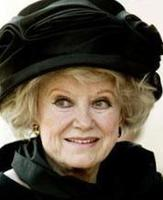


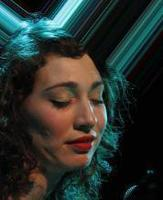


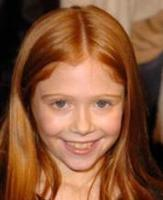


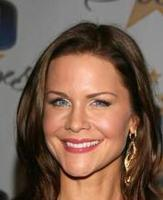


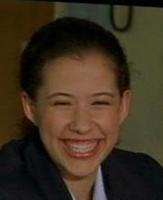


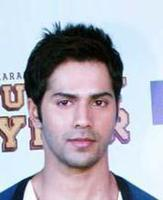


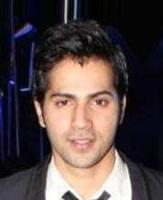


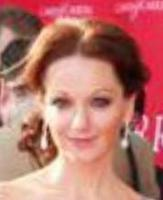


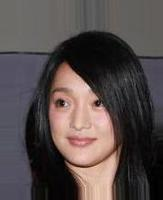


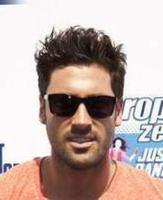

In [25]:
#select random images of the test partition
df_to_test = df_test.iloc[: 10, :]

for _, row in df_to_test.iterrows():
    display_result(row["image_id"], row["gender"])

In [27]:
model_.save("test_model_save.h5")

#### Additional code: batch prediction with flow from dataframe

In [26]:
def predict(img: pd.DataFrame) -> np.ndarray:
    """
    @param img: pandas DataFrame containing the image paths under image_id
    
    :return: numpy array with boolean predictions.
    """
    datagen =  ImageDataGenerator(
      rescale=1./255,
      preprocessing_function=preprocess_input,

    )

    generator = datagen.flow_from_dataframe(img,
                                            suffle=False,
                                            batch_size=len(img),
                                            x_col="image_id", 
                                            class_mode=None,
                                            image_size=(IMG_WIDTH, IMG_HEIGHT))
    return model_.predict(generator, steps=len(img))

predict(df_imgs.loc[:10]) >= 0.5

Found 11 validated image filenames.


array([[False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False]])